<a href="https://colab.research.google.com/github/nistha99srivastava/Fake_news_detection_using_R/blob/main/R_mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About Project

PROJECT TOPIC  : Exploratory Analysis and fake news classification on Buzzfeed News

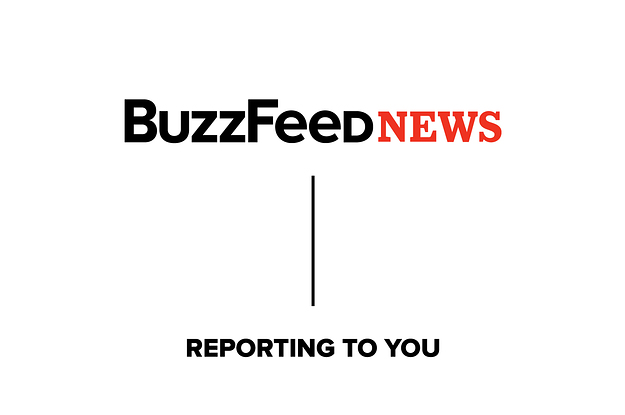


BY


*  KRITI SINGH - 17070124035
*  NISTHA SRIVASTAVA - 17070124046





# Data loading and preprocessing

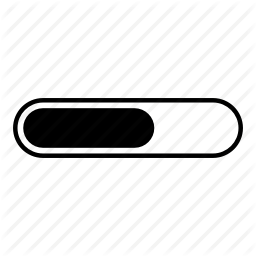

Installing and importing necessary libraries

In [ ]:
install.packages("tm")
install.packages("plyr")
install.packages("reshape2")
install.packages("e1071")
install.packages("glmnet")
install.packages("randomForest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Import libraries
library(tm) # for NLP
library(plyr) #  for pre-processing 
library(tidyverse) # for pre-processing and visualisation
library(reshape2) # for melt function
library(e1071) # for Naive Bayes classifier
library(glmnet) # for Logistic Regression classifier
library(randomForest) # for Random Forest classifier


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-1

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




Data loading

In [ ]:
buzzfeed_real <- read_csv('/content/BuzzFeed_real_news_content.csv')


── Column specification ────────────────────────────────────────────────────────
cols(
  id = col_character(),
  title = col_character(),
  text = col_character(),
  url = col_character(),
  top_img = col_character(),
  authors = col_character(),
  source = col_character(),
  publish_date = col_character(),
  movies = col_character(),
  images = col_character(),
  canonical_link = col_character(),
  meta_data = col_character()
)




In [ ]:
buzzfeed_fake <- read_csv('/content/BuzzFeed_fake_news_content.csv')


── Column specification ────────────────────────────────────────────────────────
cols(
  id = col_character(),
  title = col_character(),
  text = col_character(),
  url = col_character(),
  top_img = col_character(),
  authors = col_character(),
  source = col_character(),
  publish_date = col_character(),
  movies = col_character(),
  images = col_character(),
  canonical_link = col_character(),
  meta_data = col_character()
)




Preprocessing and feature engineering

In [ ]:
# merge data frames and delete old data frames 
buzzfeed_df = rbind(buzzfeed_real, buzzfeed_fake)

# adding new column of type for categorising document as real or fake 
buzzfeed_df$type <- sapply(strsplit(buzzfeed_df$id, "_"), head,  1)

In [ ]:
# check the dimensions of the datset
dim(buzzfeed_df)

[1] 182  13

In [ ]:
# check the summary of dataset
summary(buzzfeed_df)

      id               title               text               url           
 Length:182         Length:182         Length:182         Length:182        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
   top_img            authors             source          publish_date      
 Length:182         Length:182         Length:182         Length:182        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
    movies             images          canonical_link      meta_data        
 Length:182         Length:182         Length:182         Length:182        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
     type          
 Length:182        
 Class :character  
 Mode  :characte

In [ ]:
# select necessary columns from the dataframe for analysis
buzzfeed_df <- buzzfeed_df %>% select(c("id","title","text","source","type","images","movies"))

In [ ]:
# movies and images as logical, if available then 1 and if not then 0
buzzfeed_df$movies<- ifelse(is.na(buzzfeed_df$movies) , 0, 1)
buzzfeed_df$images<- ifelse(is.na(buzzfeed_df$images) , 0, 1)
# We assume that "addictinginfo.org" is one news source with different url or source
# Hence,combining all sources of "addictinginfo.org" into one for our analysis.
buzzfeed_fake$source <- gsub("www.addic|author.addic", "addic",buzzfeed_fake$source)
buzzfeed_real$source <- gsub("www.addic|author.addic", "addic",buzzfeed_real$source)

# Exploratory data analysis

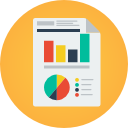

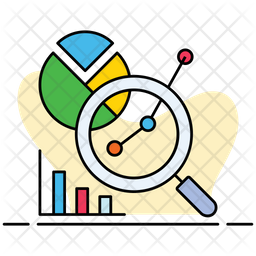

 Q. Which sources publish real news?

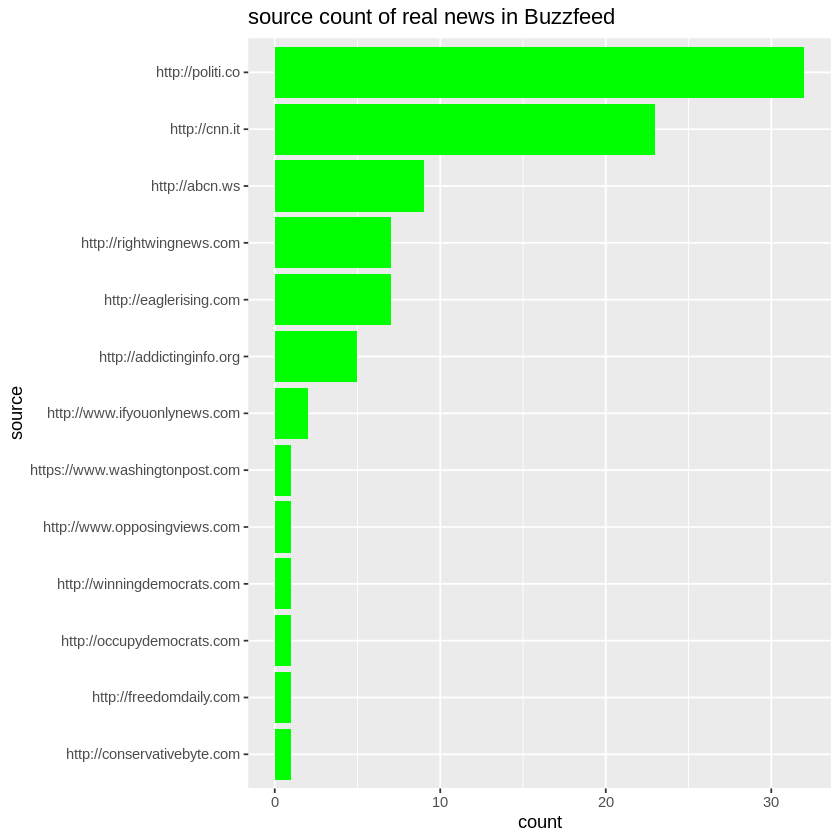

In [ ]:
buzzfeed_real$source <- with(buzzfeed_real, reorder(source, source, function(x) length(x)))
ggplot(data = buzzfeed_real) +
  ggtitle("source count of real news in Buzzfeed") +
  geom_bar(aes(x= source),fill = "green") + coord_flip()



*   From the above plot we observed that,the politi.co reports maximum real news followed by cnn.it with a count of 32 and 23 respectively.




Q. Which sources publish maximum fake news?

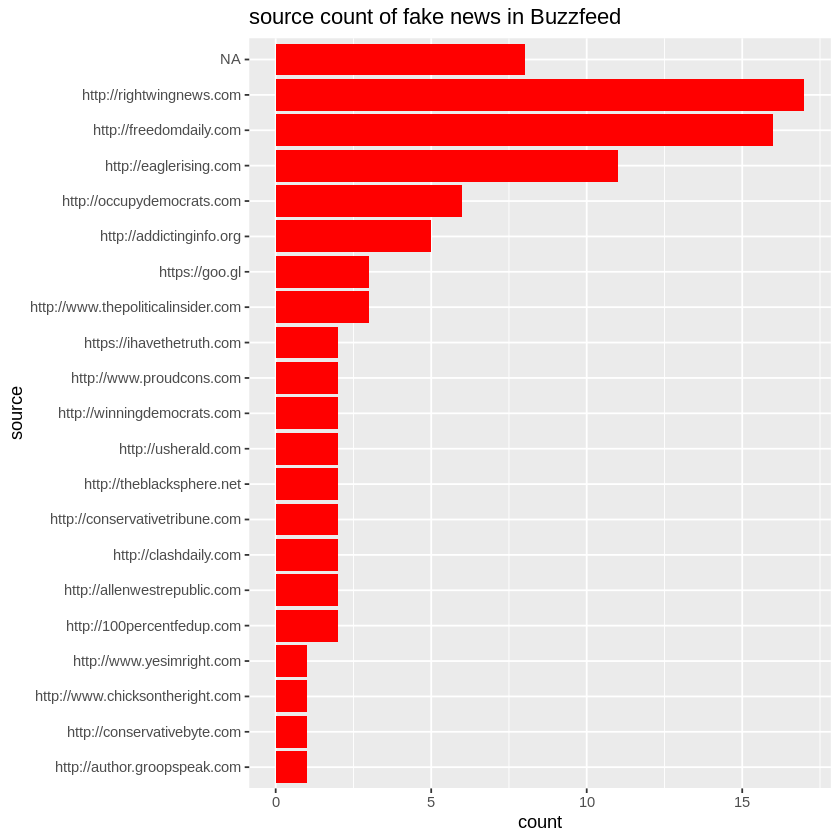

In [ ]:
buzzfeed_fake$source <- with(buzzfeed_fake,reorder(source, source, function(x) length(x))) 
ggplot(buzzfeed_fake) +
   ggtitle("source count of fake news in Buzzfeed") +
  geom_bar(aes(x=source),fill = "red") + coord_flip()



*   Above plot shows that,the rightwingsnews reports maximum fakenews with a count of 18. Also, the number of fake news sources are more than the number of real news sources.




Q. Is there any common source which reports both real and fake news?

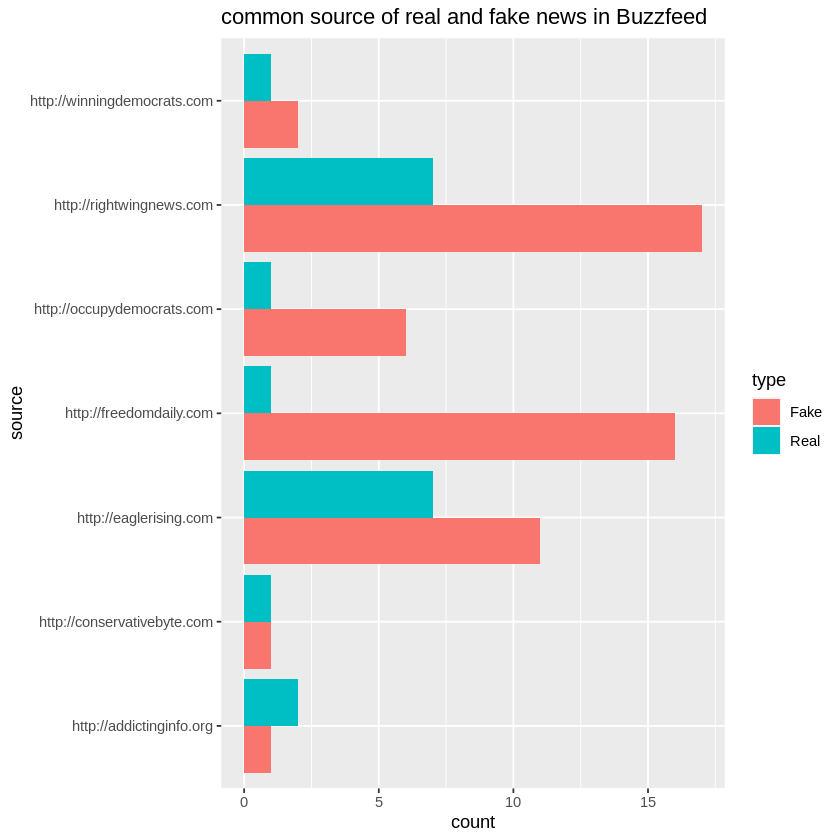

In [ ]:
# Check for common sources of fake news and real news
common_source <- intersect(buzzfeed_real$source,buzzfeed_fake$source)
source_type_counts = table(buzzfeed_df$source, buzzfeed_df$type)

# Bar chart of source 
ggplot(buzzfeed_df[which(buzzfeed_df$source %in% common_source),]) + 
  geom_bar(aes(x = source,fill = type),position = "dodge") + coord_flip() +
  ggtitle("common source of real and fake news in Buzzfeed") 



*   There are eight common sources of real and fake news. This is interesting that the fake news are more reported by these sources as compared to real news. 




Q. Do sources include movies in the news to get more attention?

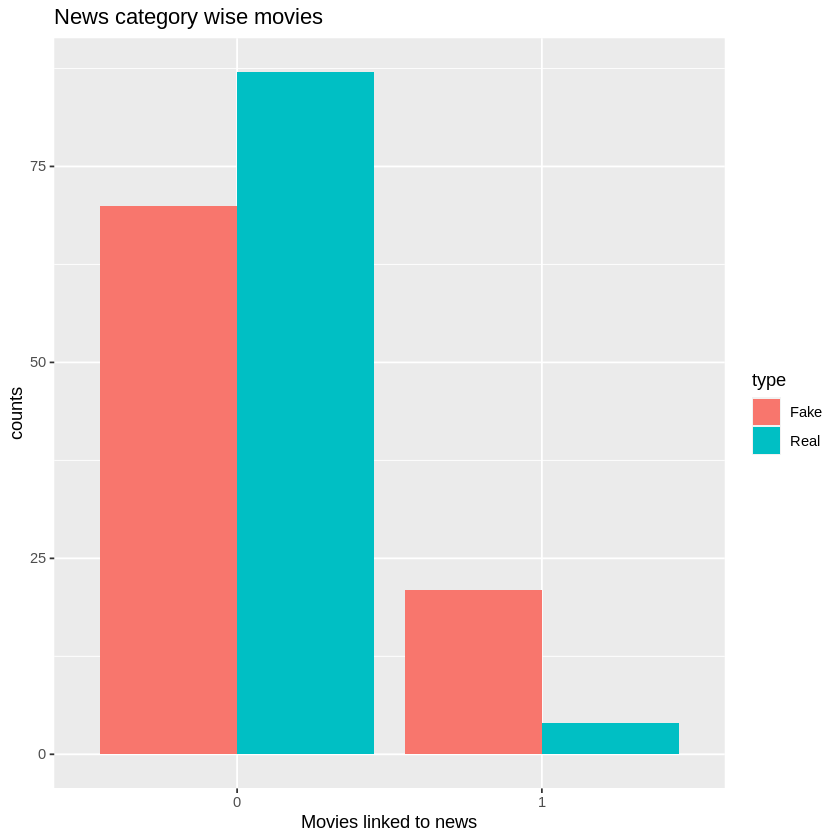

In [ ]:
# movies
ggplot(buzzfeed_df) +
  geom_bar(aes(x= factor(movies), fill = type),position = "dodge")  +
  xlab("Movies linked to news") + ylab("counts") + 
  theme() + ggtitle("News category wise movies") 



*   From the above plot, We observe that most of the news are reported without including the movie clips. 



Q. Do sources include images in all the news as images provides visual cues?

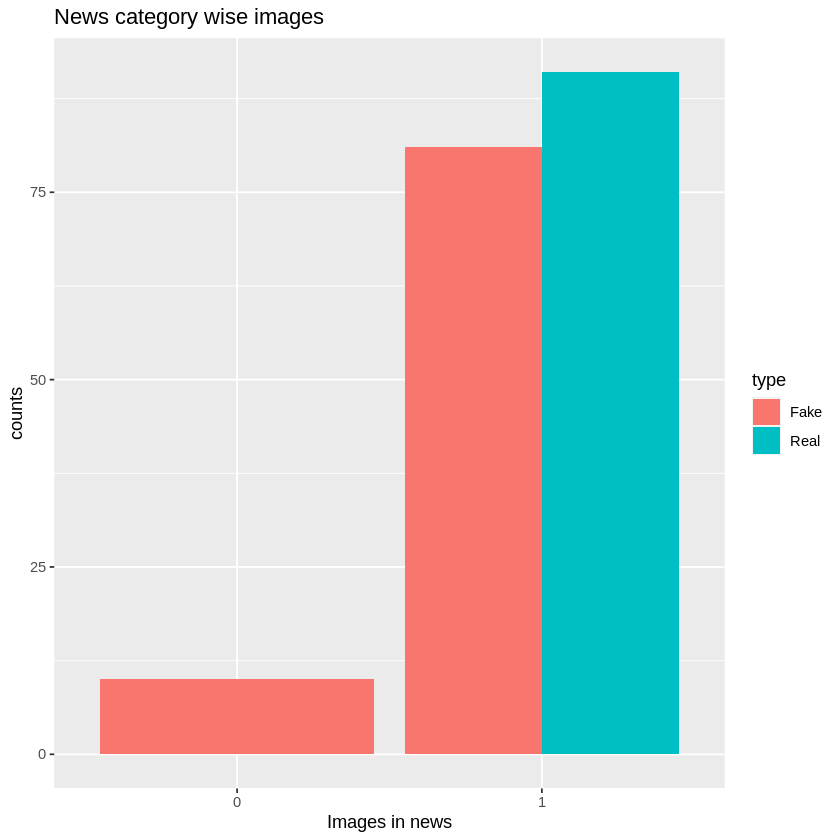

In [ ]:
# images
ggplot(buzzfeed_df) +
  geom_bar(aes(x= as.factor(images), fill = type),position = "dodge")+
  xlab("Images in news") + ylab("counts") + 
  theme() + ggtitle("News category wise images") 



*   From the above plot we observe that all the real news sources included images in their articles. We may say that images acts as a proof to there news.
*   However, this variable gives us some insights that images are important part of real news articles. 



In [ ]:
# to hide warnings
options(warn=-1)

In [ ]:
clean_text <- function(x){ 
  gsub("…|⋆|–|‹|”|“|‘|’", " ", x) 
}


preprocess_corpus <- function(corpus){
  # Convert the text to lower case
  corpus <- tm_map(corpus, content_transformer(tolower))
  # Remove numbers
  corpus <- tm_map(corpus, removeNumbers)
  # Remove punctuations
  corpus <- tm_map(corpus, removePunctuation)
  # Remove special characters from text
  corpus <- tm_map(corpus, clean_text)
  # Remove english common stopwords
  corpus <- tm_map(corpus, removeWords, stopwords("english"))
  # Remove name of newspapers from the corpus
  corpus <- tm_map(corpus, removeWords, c("eagle rising","freedom daily"))
  # 'stem' words to root words
  corpus <- tm_map(corpus,stemDocument)
  # Eliminate extra white spaces
  corpus <- tm_map(corpus, stripWhitespace)
  return (corpus)
}

Function to find top 20 category reprsentative words

In [ ]:
find_category_representative_words_using_chi_sq <- function(dtf_matrix, categories, top_n=20){
  dtm_df <- data.frame(dtf_matrix)
  # find top features using chi-sq test 
  chi2vals <- apply(dtf_matrix, 2, function(x){
    chisq.test(as.numeric(x), categories)$statistic
  })
  features_subset <- names(sort(chi2vals, decreasing = TRUE))[1:top_n]
  
  # Compute term frequency for top terms in both categories 
  dtm_df$NewsType <- categories
  cat_freq_df <- dtm_df %>% group_by(NewsType) %>% summarise_each(funs(sum))
  top_words_freq <- cat_freq_df[, c(features_subset, "NewsType")]
  return (top_words_freq)
}

In [ ]:
install.packages("SnowballC")
library("SnowballC")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Using NewsType as id variables



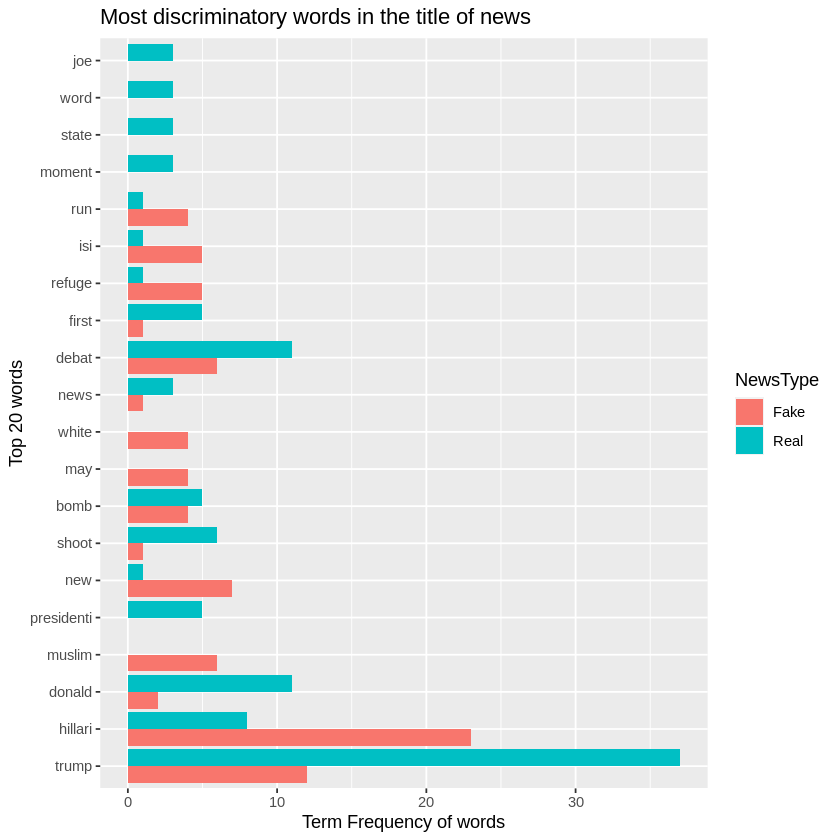

In [ ]:
# Buzzfeed title corpus
title_corpus <- Corpus(VectorSource(buzzfeed_df$title))
# convert title corpus to document term matrix
title_dtm <- DocumentTermMatrix(preprocess_corpus(title_corpus))
title_dtm_matrix <- as.matrix(title_dtm)
# finding top 20 words in the news title for both categories
title_top_words_freq <- find_category_representative_words_using_chi_sq(title_dtm_matrix,buzzfeed_df$type,20)
# ploting category wise term frequency of the top 20 discriminatory words in the news title 
ggplot(melt(title_top_words_freq),aes(x =variable, y=value,fill = NewsType)) + geom_col(position = "dodge") + coord_flip() + xlab("Top 20 words") + ylab("Term Frequency of words") + 
  theme() + ggtitle("Most discriminatory words in the title of news")



*  Plot shows that some words like muslim, isi,refuge,white,hillari are representative of fake news whereas words like presidenti,shoot, bomb,debat,state, donald, trump are representative of real news.




Using NewsType as id variables



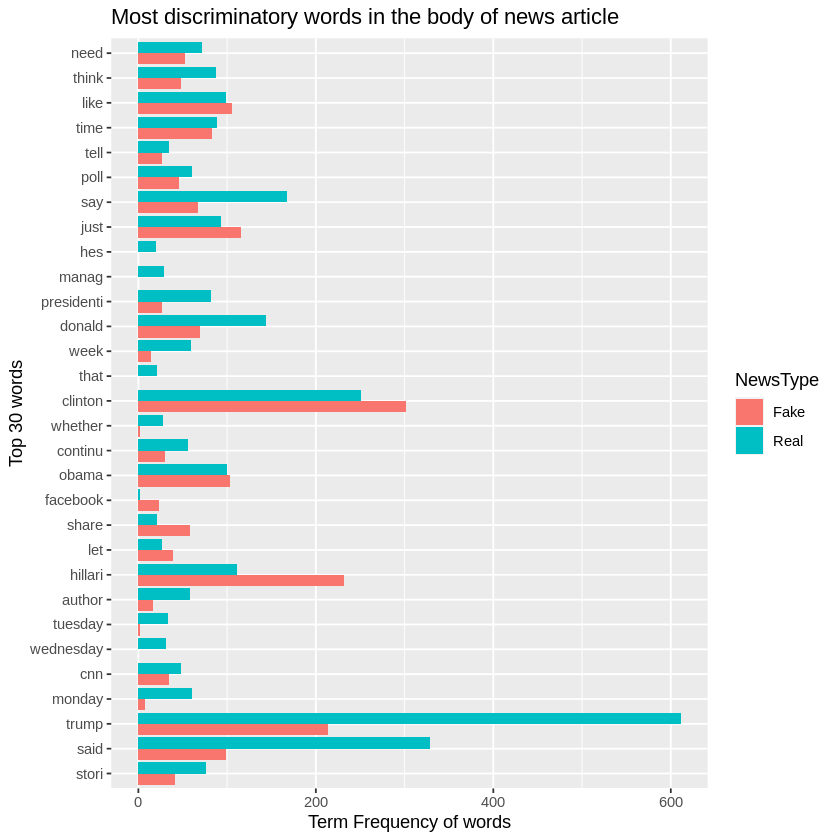

In [ ]:
# Buzzfeed text body corpus
body_corpus <- Corpus(VectorSource(buzzfeed_df$text))
# convert body corpus to document term matrix
body_dtm <- DocumentTermMatrix(preprocess_corpus(body_corpus))
body_dtm_matrix <- as.matrix(body_dtm)
# finding top 30 words in the news body for both categories
body_top_words_freq <- find_category_representative_words_using_chi_sq(body_dtm_matrix,buzzfeed_df$type,30)
# ploting category wise term frequency of the top 30 discriminatory words in the news article body
ggplot(melt(body_top_words_freq),aes(x =variable, y=value,fill = NewsType)) + 
  geom_col(position = "dodge") + coord_flip() + xlab("Top 30 words") + ylab("Term Frequency of words") + 
  theme() + ggtitle("Most discriminatory words in the body of news article") 



*  From the above plot, we notice that words like hillari, clinton, obama are the discriminatory words in the news body. Though these words appear in real news as well but they are more associated with fake news. The words like donald, trump,said,stori,think,need, are more associated with real news




Analysis on title length

Q. Do the title length of fake news title is smaller than the real news title?

In [ ]:
# length of title for histogram
title_length <- rowSums(title_dtm_matrix)
# data frame of title length with categories
tl_df <- data.frame(title_length, buzzfeed_df$type)

# perform t-test
t.test(tl_df[tl_df$buzzfeed_df.type == "Real",]$title_length, tl_df[tl_df$buzzfeed_df.type == "Fake",]$title_length)


	Welch Two Sample t-test

data:  tl_df[tl_df$buzzfeed_df.type == "Real", ]$title_length and tl_df[tl_df$buzzfeed_df.type == "Fake", ]$title_length
t = -2.3407, df = 177.45, p-value = 0.02036
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.4582691 -0.1241485
sample estimates:
mean of x mean of y 
 7.021978  7.813187 


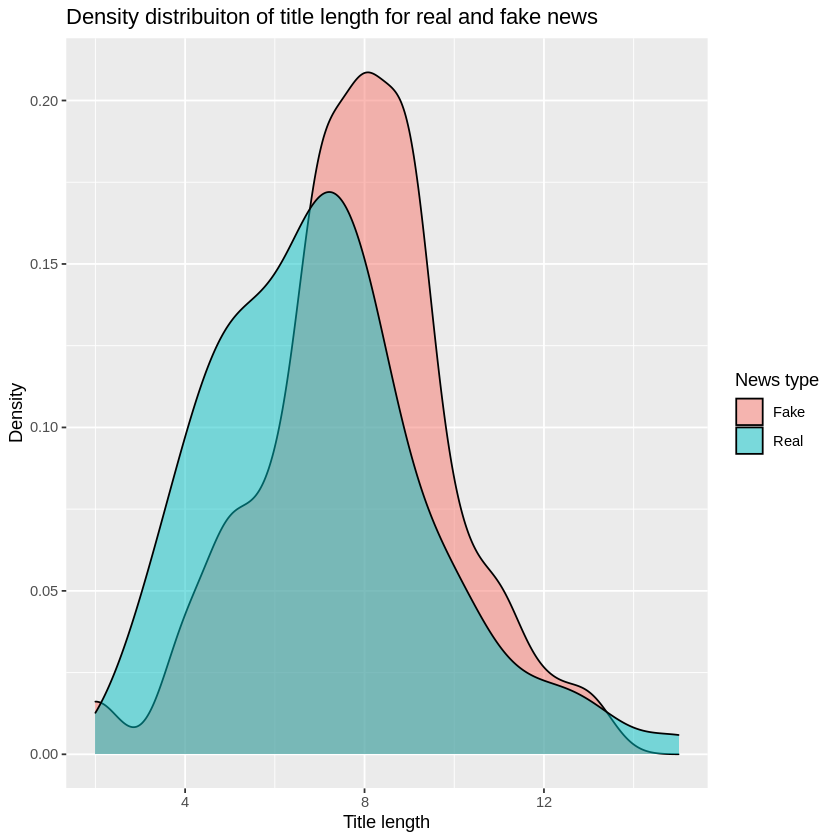

In [ ]:
# plotting histogram of title length
ggplot(tl_df ,aes(x = title_length, fill = buzzfeed_df.type)) +
  geom_density(alpha=0.5) +
  guides(fill=guide_legend(title="News type")) + 
  xlab("Title length") + ylab("Density") + theme() + 
  ggtitle("Density distribuiton of title length for real and fake news") 



*   The title length of fake news is slighly larger than the real news




# Real & Fake news classification -  by news title

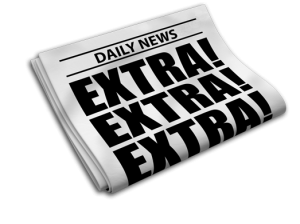

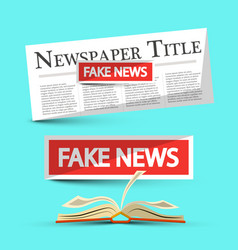

Train and test data split

In [ ]:
set.seed(123)
n_obs <- nrow(buzzfeed_df)
prop_split <- .75
training_index <- sample(1:n_obs, round(n_obs * prop_split))

Fake news detection from title of the news article

In [ ]:
# Remove sparse terms 
sparse_title_dtm <- removeSparseTerms(title_dtm, .997) # 750 terms
sparse_title_dtm 

<<DocumentTermMatrix (documents: 182, terms: 750)>>
Non-/sparse entries: 1335/135165
Sparsity           : 99%
Maximal term length: 15
Weighting          : term frequency (tf)

In [ ]:
title_dtm <- as.matrix(sparse_title_dtm)
# set train and test set for title dtm
y_true <- as.matrix(buzzfeed_df$type)
x_train <- title_dtm[training_index, ]
x_test <- title_dtm[-training_index, ]

 Naive Bayes Classifier as Base line model

In [ ]:
nb_title <- naiveBayes(x=x_train , y=as.factor(y_true[training_index]))
predicted_rf_title <- predict(nb_title, x_test)
accuracy_nb_title <- sum(y_true[-training_index] == predicted_rf_title)/ length(predicted_rf_title)
accuracy_nb_title

[1] 0.4565217



*   The accuracy of Naive Bayes classifier on title dtm is only 45% which means that, there are only 45% news in the test dataset that the classifier predicts correctly.




Logistic Regression Classifier

In [ ]:
glm_fit_title <- glmnet(x_train , y_true[training_index], family = "binomial")
predicted_glm_title <- predict(glm_fit_title, x_test, type = "class")
accuracy_glm_title <- sum(y_true[-training_index] == predicted_glm_title)/ length(predicted_glm_title)
accuracy_glm_title

[1] 0.6326087



*   We observe that logistic regression perform better than Naive Bayes classifier on title dtm with an accuracy of 61%. 




Random Forest Classifier

In [ ]:
set.seed(123)
rf_title <- randomForest(x=x_train, y=as.factor(y_true[training_index]),ntree = 50)
rf_title


Call:
 randomForest(x = x_train, y = as.factor(y_true[training_index]),      ntree = 50) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 27

        OOB estimate of  error rate: 44.12%
Confusion matrix:
     Fake Real class.error
Fake   34   32   0.4848485
Real   28   42   0.4000000

In [ ]:
predicted_rf_title <- predict(rf_title, newdata=x_test)
accuracy_rf_title <- sum(y_true[-training_index] == predicted_rf_title)/ length(predicted_rf_title)
accuracy_rf_title 


[1] 0.7173913



*   The accuracy of random forest classifier is 71% which is better than logistic regression and Naive Bayes classifier on the terms used in the title of news.




# Real & Fake news classification -  by news body

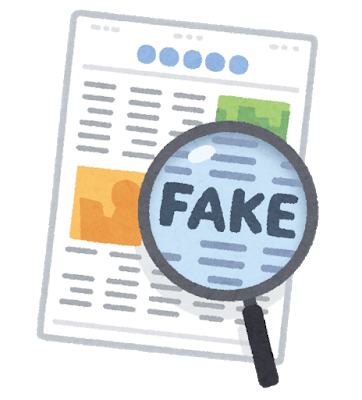

In [ ]:
# Let's remove some terms that don't appear very often and making body_dtm denser
body_corpus <- Corpus(VectorSource(buzzfeed_df$text))
body_dtm <- DocumentTermMatrix(preprocess_corpus(body_corpus))
sparse_body_dtm <- removeSparseTerms(body_dtm, 0.97) # 1337 terms
sparse_body_dtm

Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, clean_text):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("english")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, c("eagle rising", "freedom daily")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, stemDocument):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, stripWhitespace):
“transformation drops documents”


<<DocumentTermMatrix (documents: 182, terms: 1337)>>
Non-/sparse entries: 23641/219693
Sparsity           : 90%
Maximal term length: 15
Weighting          : term frequency (tf)

In [ ]:
body_dtm <- as.matrix(sparse_body_dtm)
# set train and test set for body dtm
y_true <- as.matrix(buzzfeed_df$type)
x_train_body <- body_dtm[training_index,]
x_test_body <- body_dtm[-training_index, ]

Naive Bayes Classifier as Base line model


In [ ]:
nb_body <- naiveBayes(x=x_train_body , y=as.factor(y_true[training_index]))
predicted_naive_body <- predict(nb_body, x_test_body)
accuracy_naive_body <- sum(y_true[-training_index] == predicted_naive_body)/ length(predicted_naive_body)
accuracy_naive_body

[1] 0.6086957



*   The accuracy of Naive Bayes is 60%,let’s train logistic
regression model and compare the accuracy.

Logistic Regression Classifier

In [ ]:
glm_fit_body <- glmnet(x_train_body , y_true[training_index], family = "binomial")
predicted_glm_body <- predict(glm_fit_body, x_test_body, type = "class")
accuracy_glm_body <- sum(y_true[-training_index] == predicted_glm_body)/ length(predicted_glm_body)
accuracy_glm_body 

[1] 0.6928261





*   The logistic regression performes better than Naive Bayes classifier with 69% accuracy. For further improvement let’s build random forest model.







Random Forest Classifier

In [ ]:
set.seed(123)
rf_body <- randomForest(x=x_train_body, y=as.factor(y_true[training_index]))
rf_body


Call:
 randomForest(x = x_train_body, y = as.factor(y_true[training_index])) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 36

        OOB estimate of  error rate: 22.79%
Confusion matrix:
     Fake Real class.error
Fake   53   13   0.1969697
Real   18   52   0.2571429

In [ ]:
predicted_rf_body <- predict(rf_body, newdata=x_test_body)
accuracy_rf_body <- sum(y_true[-training_index] == predicted_rf_body)/ length(predicted_rf_body)
accuracy_rf_body

[1] 0.8043478



*  We observe that the random forest is better than other two model with an accuracy of 80%.




# Conclusion

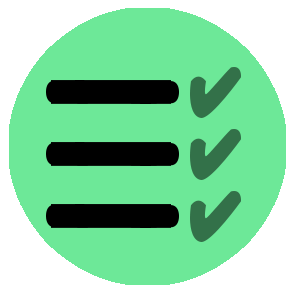



*   We performed detailed exploratory data analysis on the real and fake news of buzzfeed dataset. We generated multiple plots of all variables for both news category.
*   We analysed unigrams and bigrams and get some interesting words and phrases which are associated with fake news and included in the title or body of the news
*   We build a binary classifiers that classify fake news and real news on the basis of terms (unigrams) appears in the title,body of the news article. 
*   The Naive-Bayes classifier is our baseline model and the Random Forest is the best model for this analysis with most accurate results of classification.

